In [52]:
import pandas as pd
import nltk
import re
import string
from collections import defaultdict
import numpy as np
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import os
import threading
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
import time
from timeit import default_timer as timer

basic_stopwords = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

basic_stopwords = stopwords.words('english')

df = pd.read_csv("dataset2.csv",encoding='latin')
df = df.drop(df.columns[[1,2,3,4]],axis=1)
df = df.rename(columns={df.columns[0]: 'target', df.columns[1]: 'tweet'})

closed_categories = ['CC', 'CD', 'DT', 'EX', 'IN', 'LS', 'MD', 'PDT', 'POS', 'PRP', 'PRP$', 'RP', 'TO', 'UH', 'WDT',
                     'WP', 'WP$', 'WRB']

vocabulary = []

def custom_lemmatizer(word, pos_tag): #takes as argument the word and the pos tag

    flag = 0
    for tag in closed_categories:
        if pos_tag == tag: #if pos tag is a close category tag, the functions returns flag with value 1
            flag = 1
            return word
    if flag == 0: #if not , the word gets lemmatized according to its part of speech
        if pos_tag.startswith("N"):
            word = wordnet_lemmatizer.lemmatize(word, wordnet.NOUN)
            vocabulary.append(word)
            return (word)
        elif pos_tag.startswith('V'):
            word = wordnet_lemmatizer.lemmatize(word, wordnet.VERB)
            vocabulary.append(word)
            return (word)
        elif pos_tag.startswith('J'):
            word = wordnet_lemmatizer.lemmatize(word, wordnet.ADJ)
            vocabulary.append(word)
            return (word)
        elif pos_tag.startswith('R'):
            word = wordnet_lemmatizer.lemmatize(word, wordnet.ADV)
            vocabulary.append(word)
            return (word)
        else:
            return word

punctuation = string.punctuation
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',tweet)
    tweet = re.sub(r"@\S+", "", tweet)                
    tweet = nltk.word_tokenize(tweet)
    remove_punctuation = str.maketrans('', '', punctuation)
    tweet = [word.translate(remove_punctuation) for word in tweet if word not in basic_stopwords and word.isalnum() and not word.isdigit()]
#     tweet = [PorterStemmer().stem(word) for word in tweet]
    tagged_tweet = nltk.pos_tag(tweet)
    tweet = [custom_lemmatizer(word[0],word[1]) for word in tagged_tweet]
    tweet = [word for word in tweet if word is not None]
    
    return tweet

start = timer()
df.tweet =df.tweet.apply(lambda x:preprocess(x)) 
end = timer()
print(end-start)

[nltk_data] Downloading package wordnet to /home/antonis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/antonis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


696.7790339040002


In [42]:
#RUN TO DOWNLOAD GLOVE EMBEDDINGS
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-02-14 20:31:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-14 20:31:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-14 20:31:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [54]:
#RUN FOR GLOVE EMBEDDINGS

embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))



Found 400000 word vectors.


In [64]:
#RUN FOR CUSTOM EMBEDDINGS
model = Word2Vec(df.tweet,window=4,workers=4,min_count=1)
all_normed_vectors = model.wv.get_normed_vectors()
model.save('model.bin')

filename = 'model.txt'
model.wv.save_word2vec_format(filename,binary=False)

word_vectors = {}

file = open('model.txt',encoding='utf-8')

for line in file:
    vector_values = line.split()
    vector = np.asarray(vector_values[1:])
    word_vectors[vector_values[0]] = vector

In [65]:
df['target'] = df['target'].replace(4,1)

tokenizer = Tokenizer()

tokenizer.fit_on_texts(df.tweet)

vocabulary = tokenizer.word_index #gia to word index

train_data, test_data = train_test_split(df, test_size=0.2,random_state=4324234)


x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet),maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet),maxlen = 30)


y_train = train_data.target
y_test = test_data.target


In [56]:
# RUN FOR GLOVE
num_words = len(vocabulary) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [57]:
#RUN FOR GLOVE
embedding_layer = tf.keras.layers.Embedding(num_words,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



In [66]:
#RUN FOR CUSTOM
num_words = len(vocabulary) + 1

embedded_matrix = np.zeros((num_words,100))
for word,i in vocabulary.items():
    embedded_vector = word_vectors.get(word)
    embedded_matrix[i] = embedded_vector



In [68]:
from keras.layers import LSTM, Conv1D, Dense, Flatten, MaxPooling1D, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint


embedding_layer = tf.keras.layers.Embedding(num_words,100,weights=[embedded_matrix],
                                       input_length=30,trainable=False)

lstm_out = 64

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.7))
model.add(LSTM(units=lstm_out))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 30, 100)           25926400  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 26, 64)            32064     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 13, 64)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 13, 64)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [69]:
training = model.fit(x_train, y_train, batch_size=1024, epochs=10,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 52s 41ms/step - loss: 0.5465 - accuracy: 0.7223 - val_loss: 0.5000 - val_accuracy: 0.7539
Epoch 2/10
1250/1250 [==============================] - 48s 39ms/step - loss: 0.5174 - accuracy: 0.7451 - val_loss: 0.4909 - val_accuracy: 0.7598
Epoch 3/10
1250/1250 [==============================] - 49s 40ms/step - loss: 0.5113 - accuracy: 0.7496 - val_loss: 0.4870 - val_accuracy: 0.7631
Epoch 4/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.5079 - accuracy: 0.7518 - val_loss: 0.4840 - val_accuracy: 0.7641
Epoch 5/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.5054 - accuracy: 0.7534 - val_loss: 0.4817 - val_accuracy: 0.7655
Epoch 6/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.5039 - accuracy: 0.7547 - val_loss: 0.4803 - val_accuracy: 0.7668
Epoch 7/10
1250/1250 [==============================] - 51s 41ms/step - loss: 0.5024 - accuracy: 0.7559 - val_loss: 0.4796 -

In [25]:
model.save('lstm2')

INFO:tensorflow:Assets written to: lstm2/assets


INFO:tensorflow:Assets written to: lstm2/assets


In [26]:
def predict_tweet_sentiment(score):
    return "Positive" if score>0.5 else "Negative"
scores = model.predict(x_test, verbose=1, batch_size=10000)
model_predictions = [predict_tweet_sentiment(score) for score in scores]

32/32 [==============================] - 11s 334ms/step


In [33]:

y_pred = model.predict(x_test)


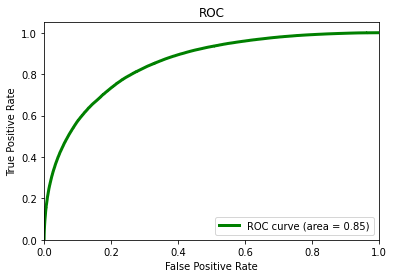

In [41]:
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report
import matplotlib.pyplot as plt


rocAuc = roc_auc_score(y_test, y_pred)

falsePositiveRate, truePositiveRate, _ = roc_curve(y_test, y_pred)

plt.figure()

plt.plot(falsePositiveRate, truePositiveRate, color='green',
         lw=3, label='ROC curve (area = %0.2f)' % rocAuc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [74]:

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_categorical_accuracy', 'categorical_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

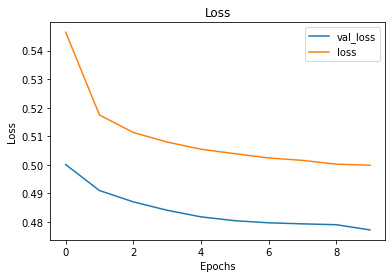

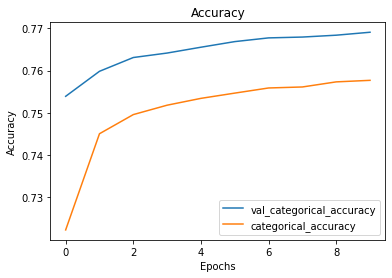

In [75]:
visualize_training_results(training)